# Evaluate the dimensionality reduction method

In [1]:
import os
import time
import pickle
import functools
import numpy as np
import math
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from cluster import spectrum
import dr_utils
import nb_utils

from sklearn.utils import murmurhash3_32
from sklearn import metrics
from sklearn import random_projection


### Use the *falcon* method (hashing)

In [2]:
_min_mz, _max_mz = 101., 1500.
fragment_mz_tolerance = 0.05

### Exhaustive comparison of dimensionality reduction methods
For n_components = 800 (the default value in falcon).
Methods:
* hashing with murmurhash32 (default method of *falcon*);
* Gaussian projection;
* Sparse projection.

100
Time needed for falcon (default) : 6.14 s
Time needed for gaussian projection : 0.61 s
Time needed for sparse projection : 0.32 s


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

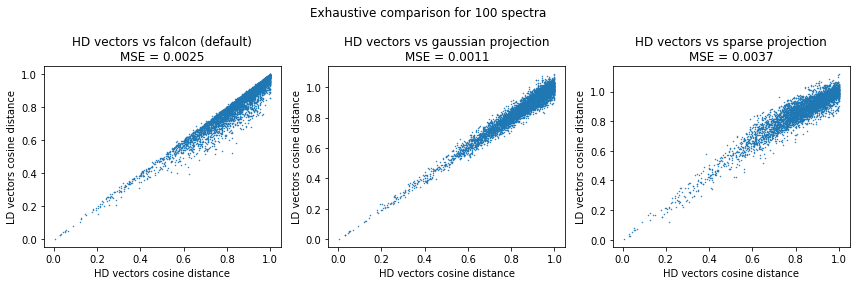

In [3]:
exportPath = os.path.abspath('dimensionReduction')
charge = 2
path = '/media/maesk/WD/falcon/PXD000561_all/spectra'
mz_split = 602 # The bucket to use
limit = 100
sps = []

cnt = 0
for sp in nb_utils.read_spectra_from_bucket(charge, path, mz_split):
    if limit is not None and cnt >= limit:
        break
    sp = nb_utils.process_spectrum(sp)
    if sp is not None:
        sps.append(sp)
        cnt = cnt + 1

nsp = len(sps)
print(nsp)

dirFig = os.path.join(exportPath, f'exhaust_charge{charge}_buck{mz_split}_{len(sps)}.png')
n_components = 800
_, min_bound, max_bound = spectrum.get_dim(_min_mz, _max_mz, fragment_mz_tolerance)

methods = ['falcon (default)', 'gaussian projection', 'sparse projection']
reduct_func = [dr_utils.reduction_falcon, dr_utils.reduction_gaussian,
               dr_utils.reduction_sparse]
vec_hd = dr_utils.sp_to_vecHD(sps, min_bound, max_bound, fragment_mz_tolerance)
MSEs = dr_utils.compare_reductions(vec_hd, n_components, reduct_func, methods, dirFig)


### Non-exhaustive comparison

Perform the dimensionality reduction for a large number of spectra but only compare a subset of
the pairwise distances.

In [ ]:
charge = 2
# path = path
mz_split = 602
n_pairs = 10**6
all_limits = [1000, 7000, 14000, 21000, 28000, None]
all_MSEs = []

for i, limit in zip(range(len(all_limits)), all_limits):
    sps = []
    cnt = 0
    for sp in nb_utils.read_spectra_from_bucket(charge, path, mz_split):
        if limit is not None and cnt >= limit:
            break
        sp = nb_utils.process_spectrum(sp)
        if sp is not None:
            sps.append(sp)
            cnt = cnt + 1
    print('Use %d spectra' % (len(sps),) )
    all_limits[i] = len(sps)

    pairs = dr_utils.generate_pairs(n_pairs, len(sps), 42)

    dirFig = os.path.join(exportPath, f'nonexhaust_charge{charge}_buck{mz_split}_{len(sps)}.png')
    n_components = 800
    _, min_bound, max_bound = spectrum.get_dim(_min_mz, _max_mz, fragment_mz_tolerance)

    methods = ['falcon (default)', 'gaussian projection', 'sparse projection']
    reduct_func = [dr_utils.reduction_falcon, dr_utils.reduction_gaussian,
                   dr_utils.reduction_sparse]
    vec_hd = dr_utils.sp_to_vecHD(sps, min_bound, max_bound, fragment_mz_tolerance)
    MSEs = dr_utils.compare_reductions(vec_hd, n_components, reduct_func, methods, dirFig, pairs = pairs)
    all_MSEs.append(MSEs)

Use 1000 spectra
Time needed for falcon (default) : 60.51 s
Time needed for gaussian projection : 1.06 s
Time needed for sparse projection : 0.46 s
Use 7000 spectra
Time needed for falcon (default) : 423.50 s
Time needed for gaussian projection : 4.44 s
Time needed for sparse projection : 3.22 s
Use 14000 spectra


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/14000 [00:00<?, ?it/s]

In [ ]:
# Plot the evolution of the MSE according to the subset size
fig, ax = plt.subplots()
for i in range(len(all_MSEs[0])):
    ax.plot(all_limits, [MSEs[i] for MSEs in all_MSEs], label=methods[i])
ax.set(title='MSE evolution for bucket %d' % (mz_split,),
       xlabel='Number of spectra', ylabel='MSE',
       ylim=(0,0.0035))
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(exportPath, f'MSE_evolution_bucket{mz_split}.png'), dpi=300)
plt.plot()